In [1]:
# Basic Import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

# Modeling
from sklearn.metrics import f1_score, classification_report, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
import warnings
warnings.filterwarnings('ignore')

In [2]:
pd.set_option('display.max_rows',5000)
pd.set_option('display.max_columns',None)

In [3]:
X=pd.read_csv('temp_train_data.csv')
Y=pd.read_csv('temp_output_train_data.csv')

In [4]:
X_TEST=pd.read_csv('temp_test_data.csv')
Y_TEST=pd.read_csv('temp_output_test_data.csv')

In [5]:
X.shape
# Y.shape

(3940, 5)

In [6]:
X.columns

Index(['fti', 't3', 'tbg', 'tsh', 'tt4'], dtype='object')

In [7]:
X_TEST.shape

(985, 5)

In [8]:
models={
    'KNN classifier': KNeighborsClassifier(),
    'naive bayes': GaussianNB(),
    'Random Forest': RandomForestClassifier(class_weight='balanced'),
    'Gradient Boosting': GradientBoostingClassifier(),
    # 'xgb': XGBClassifier(),
    'neural_network': MLPClassifier(),
    'adb': AdaBoostClassifier(),
}


params={
    'knn classifier':{'n_neighbors':[3,4,5], 'weights':['distance'], 'algorithm':['auto', 'ball_tree', 'kd_tree', 'brute']},
    'naive bayes': {},
    'random forest':{'min_samples_split':[15,20,25],'criterion':['log_loss','gini','entropy'],'max_features':['sqrt','log2'], 'max_depth':[11]},
    'gradient boost':{'learning_rate':[0.1, 0.2,0.3], 'max_features': ['log2','sqrt']},
    # 'xgb': {'booster': ['gbtree', 'gblinear'], 'learning_rate':[0.1,0.01,0.001],
    #         'colsample_bylevel':[0.1], 'scale_pos_weight':[1,2],'updater':['grow_colmaker'],
    #         'gamma':[10,20], 'max_depth':[5,7,9]},
    'neural_network': {'activation':['relu'], 'learning_rate':['constant'], 'learning_rate_init':[0.01,0.1]},
    'adb':{'n_estimators':[10],'learning_rate':[0.1,0.2,0.3, 0.4,0.5]},
}

train_pred_proba=[]
test_pred_proba=[]

for i in range(len(models)):
    gd_cv= GridSearchCV(models[list(models.keys())[i]], param_grid=params[list(params.keys())[i]], scoring='accuracy', cv=3)
    print(f"Dataset shape: {X.shape}")
    
    gd_cv.fit(X,Y)
    
    print("Model:",models[list(models.keys())[i]])
    print("Best Parameters: ",gd_cv.best_params_)
    training_predictions=gd_cv.predict(X)
    train_pred_proba.append(pd.Series(gd_cv.predict_proba(X)[:,1]))
    test_predictions=gd_cv.predict(X_TEST)
    test_pred_proba.append(pd.Series(gd_cv.predict_proba(X_TEST)[:,1]))
    
    
    print(f"Misclassified training features: {(training_predictions!=Y['disease']).sum()}")
    print(f"f1 score: {f1_score(Y, training_predictions,average='macro')}")
    print(f"Classification report: \n{classification_report(Y,training_predictions)}")
    print(f"Roc_auc_score: {roc_auc_score(Y,training_predictions,average='macro')}")
    
    print(f"Misclassified test features: {(test_predictions!=Y_TEST['disease']).sum()}")
    print(f"f1 score: {f1_score(Y_TEST, test_predictions,average='macro')}")
    print(f"Classification report: \n{classification_report(Y_TEST,test_predictions)}")
    print(f"Roc_auc_score: {roc_auc_score(Y_TEST,test_predictions,average='macro')}")
    
    print("=======================================================================================\n")
    
    


Dataset shape: (3940, 5)
Model: KNeighborsClassifier()
Best Parameters:  {'algorithm': 'brute', 'n_neighbors': 5, 'weights': 'distance'}
Misclassified training features: 305
f1 score: 0.9018529993640088
Classification report: 
              precision    recall  f1-score   support

           0       0.95      0.94      0.95      2894
           1       0.84      0.87      0.86      1046

    accuracy                           0.92      3940
   macro avg       0.90      0.91      0.90      3940
weighted avg       0.92      0.92      0.92      3940

Roc_auc_score: 0.9064025788173857
Misclassified test features: 170
f1 score: 0.7805948637316562
Classification report: 
              precision    recall  f1-score   support

           0       0.88      0.88      0.88       718
           1       0.68      0.67      0.68       267

    accuracy                           0.83       985
   macro avg       0.78      0.78      0.78       985
weighted avg       0.83      0.83      0.83       985


In [9]:
final_pred=pd.concat(test_pred_proba, axis=1).mean(axis=1)
test_probabilities=pd.concat(test_pred_proba,axis=1)
test_probabilities['mean']=final_pred

In [10]:
test_probabilities.head()

,0,1,2,3,4,5,6,mean
0,0.000000,0.005448,0.000681,0.013737,0.458826,0.013656,0.340404,0.118965
1,1.000000,1.000000,0.966375,0.876338,0.536280,0.948655,0.522086,0.835676
2,0.000000,0.006907,0.005175,0.012170,0.460627,0.015293,0.340404,0.120082
3,0.000000,0.042647,0.059944,0.019925,0.466670,0.086526,0.340404,0.145160
4,0.381642,0.007877,0.880242,0.672419,0.515676,0.505547,0.522086,0.497927


In [11]:
fpr, tpr, thresholds = roc_curve(Y_TEST, final_pred)

In [12]:
from sklearn.metrics import accuracy_score
accuracy_ls = []
for thres in thresholds:
    y_pred = np.where(final_pred>thres,1,0)
    accuracy_ls.append(accuracy_score(Y_TEST, y_pred, normalize=True))
    
accuracy_ls = pd.concat([pd.Series(thresholds), pd.Series(accuracy_ls)],
                        axis=1)
accuracy_ls.columns = ['thresholds', 'accuracy']
accuracy_ls.sort_values(by='accuracy', ascending=False, inplace=True)
accuracy_ls.head()

,thresholds,accuracy
158,0.343635,0.872081
159,0.340590,0.871066
157,0.347173,0.871066
160,0.328077,0.870051
161,0.324929,0.869036


In [13]:
accuracy_ls

,thresholds,accuracy
158,0.343635,0.872081
159,0.340590,0.871066
157,0.347173,0.871066
160,0.328077,0.870051
161,0.324929,0.869036
155,0.354341,0.868020
156,0.354000,0.867005
146,0.377499,0.867005
147,0.376615,0.867005
149,0.371765,0.867005


In [14]:
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

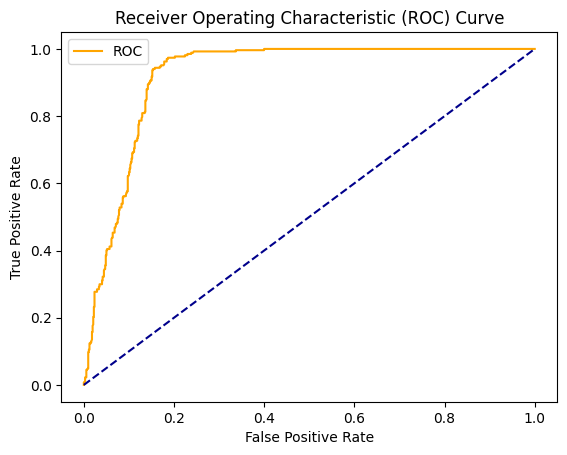

In [15]:
plot_roc_curve(fpr,tpr)

In [16]:
xgb_class=XGBClassifier(booster='gbtree', colsample_bylevel=0.1, colsample_bynode=0.1, 
                        colsample_bytree=1, learning_rate=0.01, num_parallel_tree=1, 
                        sampling_method='uniform', scale_pos_weight=2, 
                        tree_method= 'auto', updater='grow_colmaker')

In [17]:
xgb_class.fit(X,Y)

[18:14:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\gbm\gbtree.cc:84: DANGER AHEAD: You have manually specified `updater` parameter. The `tree_method` parameter will be ignored. Incorrect sequence of updaters will produce undefined behavior. For common uses, we recommend using `tree_method` parameter instead.


XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=0.1, colsample_bynode=0.1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=None, gpu_id=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=1,
              predictor=None, random_state=None, ...)

In [18]:
xgb_train_pred=pd.DataFrame(xgb_class.predict(X),columns=["Prediction"])
xgb_train_prob=pd.DataFrame(xgb_class.predict_proba(X))

In [19]:
xgb_train_pred['disease']=Y

In [20]:
print(f"Blunders: {xgb_train_pred[(xgb_train_pred['Prediction']!=xgb_train_pred['disease']) & (xgb_train_pred['disease']==1)].shape[0]}")

Blunders: 72


In [21]:
print(f"Misclassification: {xgb_train_pred[(xgb_train_pred['Prediction']!=xgb_train_pred['disease'])].shape[0]}")

Misclassification: 542


In [22]:
xgb_train_pred2=xgb_train_pred.copy()

In [23]:
(xgb_train_prob[0].max())

0.7818892

In [24]:
xgb_train_pred2['Prediction']=np.where(xgb_train_prob[0]>0.58,0,1)

In [25]:
print(f"Misclassification: {xgb_train_pred2[(xgb_train_pred2['Prediction']!=xgb_train_pred2['disease'])].shape[0]}")

Misclassification: 543


In [26]:
print(f"Blunders: {xgb_train_pred2[(xgb_train_pred2['Prediction']!=xgb_train_pred2['disease']) & (xgb_train_pred2['disease']==1)].shape[0]}")

Blunders: 24


In [27]:
xgb_train_pred.shape

(3940, 2)

In [28]:
print(classification_report(Y,xgb_train_pred2['Prediction']))

              precision    recall  f1-score   support

           0       0.99      0.82      0.90      2894
           1       0.66      0.98      0.79      1046

    accuracy                           0.86      3940
   macro avg       0.83      0.90      0.84      3940
weighted avg       0.90      0.86      0.87      3940



In [29]:
xgb_test_pred=pd.DataFrame(xgb_class.predict(X_TEST),columns=['Prediction'])
xgb_test_prob=pd.DataFrame(xgb_class.predict_proba(X_TEST))

In [30]:
xgb_test_pred['disease']=Y_TEST

In [31]:
print(f"Blunders: {xgb_test_pred[(xgb_test_pred['Prediction']!=xgb_test_pred['disease']) & (xgb_test_pred['disease']==1)].shape[0]}")


Blunders: 31


In [32]:
print(f"Blunders: {xgb_test_prob[(xgb_test_pred['Prediction']!=xgb_test_pred['disease']) & (xgb_test_pred['disease']==1)].shape[0]}")
xgb_test_prob[(xgb_test_pred['Prediction']!=xgb_test_pred['disease']) & (xgb_test_pred['disease']==1)].head()

Blunders: 31


,0,1
6,0.553530,0.446470
44,0.516784,0.483216
130,0.548764,0.451236
218,0.555834,0.444166
278,0.512452,0.487548


In [33]:
print(f"Misclassifications: {xgb_test_pred[(xgb_test_pred['Prediction']!=xgb_test_pred['disease'])].shape[0]}")

Misclassifications: 129


In [34]:
print(f"Misclassifications: {xgb_test_prob[(xgb_test_pred['Prediction']!=xgb_test_pred['disease'])].shape[0]}")
xgb_test_prob[(xgb_test_pred['Prediction']!=xgb_test_pred['disease'])].head()

Misclassifications: 129


,0,1
4,0.390049,0.609951
6,0.553530,0.446470
19,0.406054,0.593946
22,0.325631,0.674369
27,0.261276,0.738724


In [35]:
xgb_test_prob[0].max()

0.7818892

In [36]:
xgb_test_pred2=xgb_test_pred.copy()

In [37]:
xgb_test_pred2['Prediction']=np.where(xgb_test_prob[0]>0.58,0,1)

In [38]:
print(f"Misclassifications: {xgb_test_pred2[(xgb_test_pred2['Prediction']!=xgb_test_pred2['disease'])].shape[0]}")


Misclassifications: 133


In [39]:
print(f"Blunders: {xgb_test_pred[(xgb_test_pred2['Prediction']!=xgb_test_pred2['disease']) & (xgb_test_pred2['disease']==1)].shape[0]}")

Blunders: 22


In [40]:
print(classification_report(xgb_test_pred2['disease'],xgb_test_pred2['Prediction']))

              precision    recall  f1-score   support

           0       0.97      0.85      0.90       718
           1       0.69      0.92      0.79       267

    accuracy                           0.86       985
   macro avg       0.83      0.88      0.84       985
weighted avg       0.89      0.86      0.87       985

